**Note :** the project unfinished (to be continued) 

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import json 
import os 

train_path='/kaggle/input/dentistry-v2i-coco-segmentation/train'
val_path='/kaggle/input/dentistry-v2i-coco-segmentation/valid'

In [2]:
import glob 

train_ann=glob.glob(os.path.join(train_path,"*.json"))[0]
val_ann=glob.glob(os.path.join(val_path,"*.json"))[0]

In [3]:
train_ann,val_ann

('/kaggle/input/dentistry-v2i-coco-segmentation/train/_annotations.coco.json',
 '/kaggle/input/dentistry-v2i-coco-segmentation/valid/_annotations.coco.json')

In [4]:
train_images=sorted(glob.glob(os.path.join(train_path,"*jpg")))
val_images=sorted(glob.glob(os.path.join(val_path,"*jpg")))

In [5]:
train_images[0],val_images[0]

('/kaggle/input/dentistry-v2i-coco-segmentation/train/0000001_png_jpg.rf.0cd144851d07ecf2b651b731a38e17b8.jpg',
 '/kaggle/input/dentistry-v2i-coco-segmentation/valid/0000005_png_jpg.rf.27d5911503f69d2a54f96a156e3094d6.jpg')

In [6]:
with open(train_ann,'r') as file:
    t_ann=json.load(file)
    
with open(val_ann,'r') as file:
    v_ann=json.load(file)

In [7]:
len(v_ann["images"])

113

In [8]:
t_ann.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

In [9]:
t_ann["categories"]

[{'id': 0, 'name': 'tooth', 'supercategory': 'none'},
 {'id': 1, 'name': '11', 'supercategory': 'tooth'},
 {'id': 2, 'name': '12', 'supercategory': 'tooth'},
 {'id': 3, 'name': '13', 'supercategory': 'tooth'},
 {'id': 4, 'name': '14', 'supercategory': 'tooth'},
 {'id': 5, 'name': '15', 'supercategory': 'tooth'},
 {'id': 6, 'name': '16', 'supercategory': 'tooth'},
 {'id': 7, 'name': '17', 'supercategory': 'tooth'},
 {'id': 8, 'name': '18', 'supercategory': 'tooth'},
 {'id': 9, 'name': '21', 'supercategory': 'tooth'},
 {'id': 10, 'name': '22', 'supercategory': 'tooth'},
 {'id': 11, 'name': '23', 'supercategory': 'tooth'},
 {'id': 12, 'name': '24', 'supercategory': 'tooth'},
 {'id': 13, 'name': '25', 'supercategory': 'tooth'},
 {'id': 14, 'name': '26', 'supercategory': 'tooth'},
 {'id': 15, 'name': '27', 'supercategory': 'tooth'},
 {'id': 16, 'name': '28', 'supercategory': 'tooth'},
 {'id': 17, 'name': '31', 'supercategory': 'tooth'},
 {'id': 18, 'name': '32', 'supercategory': 'tooth'},
 

In [10]:
t_ann["images"][0]

{'id': 0,
 'license': 1,
 'file_name': '0000204_png_jpg.rf.8d6dc3e07539b8858f851c1e37a34e86.jpg',
 'height': 64,
 'width': 64,
 'date_captured': '2023-12-25T03:00:21+00:00'}

In [11]:
t_ann["annotations"][0]

{'id': 0,
 'image_id': 0,
 'category_id': 33,
 'bbox': [30, 32, 2.188, 4.896],
 'area': 10.711,
 'segmentation': [[30.096,
   36.458,
   31.574,
   36.667,
   31.811,
   31.771,
   29.623,
   31.771,
   30.096,
   36.458]],
 'iscrowd': 0}

In [12]:
import shutil
import skimage
import tifffile

def create_mask(image_info,annotation ,cat, output_folder):
    # Create an empty mask as a numpy array
    mask_np = np.zeros((image_info['height'], image_info['width']), dtype=np.uint16)

    for ann in annotation:
        if ann['image_id'] == image_info['id']:
            category_id=ann['category_id']
            category_info = next((item for item in cat if item['id'] == category_id), None)
            object_number =255
            # Extract segmentation polygon
            for seg in ann['segmentation']:
                # Convert polygons to a binary mask and add it to the main mask
                rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
                mask_np[rr, cc] = object_number

    # Save the numpy array as a TIFF using tifffile library
    mask_path = os.path.join(output_folder, image_info['file_name'].replace('.jpg', '_mask.tif'))
    tifffile.imwrite(mask_path, mask_np)

    print(f"Saved mask for {image_info['file_name']} to {mask_path}")


def main(json_file, mask_output_folder, image_output_folder, original_image_dir):
    # Load COCO JSON annotations
    with open(json_file, 'r') as f:
        data = json.load(f)

    images = data['images']
    annotations = data['annotations']
    categories=data['categories']

    # Ensure the output directories exist
    if not os.path.exists(mask_output_folder):
        os.makedirs(mask_output_folder)
    if not os.path.exists(image_output_folder):
        os.makedirs(image_output_folder)

    for img in images:
        # Create the masks
        create_mask(img, annotations,categories, mask_output_folder)
        
        # Copy original images to the specified folder
        original_image_path = os.path.join(original_image_dir, img['file_name'])
    
        new_image_path = os.path.join(image_output_folder, os.path.basename(original_image_path))
        shutil.copy2(original_image_path, new_image_path)
        print(f"Copied original image to {new_image_path}")



In [13]:
# for traininf images 
import numpy as np 
path_train="/kaggle/input/dentistry-v2i-coco-segmentation/train"
json_train = train_ann
mask_output_folder = '/kaggle/working/train/masks'  
image_output_folder = '/kaggle/working/train/images'  
main(train_ann, mask_output_folder, image_output_folder,path_train)

Saved mask for 0000204_png_jpg.rf.8d6dc3e07539b8858f851c1e37a34e86.jpg to /kaggle/working/train/masks/0000204_png_jpg.rf.8d6dc3e07539b8858f851c1e37a34e86_mask.tif
Copied original image to /kaggle/working/train/images/0000204_png_jpg.rf.8d6dc3e07539b8858f851c1e37a34e86.jpg
Saved mask for 0000166_png_jpg.rf.914d94881d77fc880baf064a0dbe9a05.jpg to /kaggle/working/train/masks/0000166_png_jpg.rf.914d94881d77fc880baf064a0dbe9a05_mask.tif
Copied original image to /kaggle/working/train/images/0000166_png_jpg.rf.914d94881d77fc880baf064a0dbe9a05.jpg
Saved mask for 0000243_png_jpg.rf.9423149e5ecaba92638dd67aac9d71ac.jpg to /kaggle/working/train/masks/0000243_png_jpg.rf.9423149e5ecaba92638dd67aac9d71ac_mask.tif
Copied original image to /kaggle/working/train/images/0000243_png_jpg.rf.9423149e5ecaba92638dd67aac9d71ac.jpg
Saved mask for 0000519_png_jpg.rf.8b3ec9961b1d89a289a945737f97ae3a.jpg to /kaggle/working/train/masks/0000519_png_jpg.rf.8b3ec9961b1d89a289a945737f97ae3a_mask.tif
Copied original im

In [14]:
path_val="/kaggle/input/dentistry-v2i-coco-segmentation/valid"
json_val = val_ann
mask_output_folder = '/kaggle/working/valid/masks'  
image_output_folder = '/kaggle/working/valid/images'  
main(json_val, mask_output_folder, image_output_folder,path_val)

Saved mask for 0000308_png_jpg.rf.88b0bc35ce301d0fe4854cce1d734a8e.jpg to /kaggle/working/valid/masks/0000308_png_jpg.rf.88b0bc35ce301d0fe4854cce1d734a8e_mask.tif
Copied original image to /kaggle/working/valid/images/0000308_png_jpg.rf.88b0bc35ce301d0fe4854cce1d734a8e.jpg
Saved mask for 0000133_png_jpg.rf.79e471f2ee885b0961914765bc35df6b.jpg to /kaggle/working/valid/masks/0000133_png_jpg.rf.79e471f2ee885b0961914765bc35df6b_mask.tif
Copied original image to /kaggle/working/valid/images/0000133_png_jpg.rf.79e471f2ee885b0961914765bc35df6b.jpg
Saved mask for 0000233_png_jpg.rf.8474a24be5d5a29fd8d26b6c882e3387.jpg to /kaggle/working/valid/masks/0000233_png_jpg.rf.8474a24be5d5a29fd8d26b6c882e3387_mask.tif
Copied original image to /kaggle/working/valid/images/0000233_png_jpg.rf.8474a24be5d5a29fd8d26b6c882e3387.jpg
Saved mask for 0000295_png_jpg.rf.a496a8b9adf0c5718e3764b47ad8f3bc.jpg to /kaggle/working/valid/masks/0000295_png_jpg.rf.a496a8b9adf0c5718e3764b47ad8f3bc_mask.tif
Copied original im

In [ ]:
import shutil
import skimage
import tifffile

def create_mask(image_info,annotation ,cat, output_folder):
    # Create an empty mask as a numpy array
    mask_np = np.zeros((image_info['height'], image_info['width']), dtype=np.uint16)

    for ann in annotation:
        if ann['image_id'] == image_info['id']:
            category_id=ann['category_id']
            category_info = next((item for item in cat if item['id'] == category_id), None)
            object_number = category_info['id']
            # Extract segmentation polygon
            for seg in ann['segmentation']:
                # Convert polygons to a binary mask and add it to the main mask
                rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
                mask_np[rr, cc] = object_number

    # Save the numpy array as a TIFF using tifffile library
    mask_path = os.path.join(output_folder, image_info['file_name'].replace('.jpg', '_mask.tif'))
    tifffile.imwrite(mask_path, mask_np)

    print(f"Saved mask for {image_info['file_name']} to {mask_path}")


def main(json_file, mask_output_folder, image_output_folder, original_image_dir):
    # Load COCO JSON annotations
    with open(json_file, 'r') as f:
        data = json.load(f)

    images = data['images']
    annotations = data['annotations']
    categories=data['categories']

    # Ensure the output directories exist
    if not os.path.exists(mask_output_folder):
        os.makedirs(mask_output_folder)
    if not os.path.exists(image_output_folder):
        os.makedirs(image_output_folder)

    for img in images:
        # Create the masks
        create_mask(img, annotations,categories, mask_output_folder)
        
        # Copy original images to the specified folder
        original_image_path = os.path.join(original_image_dir, img['file_name'])
    
        new_image_path = os.path.join(image_output_folder, os.path.basename(original_image_path))
        shutil.copy2(original_image_path, new_image_path)
        print(f"Copied original image to {new_image_path}")




In [ ]:
# for traininf images 
path_train="/kaggle/input/dentistry-v2i-coco-segmentation/train"
json_train = train_ann
mask_output_folder = '/kaggle/working/train/masks'  
image_output_folder = '/kaggle/working/train/images'  
main(train_ann, mask_output_folder, image_output_folder,path_train)

In [ ]:
path_val="/kaggle/input/dentistry-v2i-coco-segmentation/valid"
json_val = val_ann
mask_output_folder = '/kaggle/working/valid/masks'  
image_output_folder = '/kaggle/working/valid/images'  
main(json_val, mask_output_folder, image_output_folder,path_val)

In [15]:
train_img_path='/kaggle/working/train/images'
train_mk_path='/kaggle/working/train/masks'
train_images = [os.path.join(train_img_path, file) for file in sorted(os.listdir(train_img_path))]
train_masks = [os.path.join(train_mk_path, file) for file in sorted(os.listdir(train_mk_path))]

In [16]:
train_images[5],train_masks[5]

('/kaggle/working/train/images/0000007_png_jpg.rf.917842da82da85fb676d7c8fc3473263.jpg',
 '/kaggle/working/train/masks/0000007_png_jpg.rf.917842da82da85fb676d7c8fc3473263_mask.tif')

In [17]:
val_img_path='/kaggle/working/valid/images'
val_mk_path='/kaggle/working/valid/masks'
val_images = [os.path.join(val_img_path, file) for file in sorted(os.listdir(val_img_path))]
val_masks = [os.path.join(val_mk_path, file) for file in os.listdir(val_mk_path)]

In [18]:
def img_to_array(img,mk):
    images=[]
    masks=[]
    for i, m in zip(img, mk):
       ig = Image.open(i)
       msk=Image.open(m)
       ig = np.array(ig)
       ig = ig/255.
       msk =np.array(msk)
       msk=msk/255.
       images.append(ig)
       masks.append(msk)
    return np.array(images),np.array(masks)

In [19]:
from PIL import Image
tn_img_arrays,tn_mk_arrays=img_to_array(train_images,train_masks)
v_img_arrays,v_mk_arrays=img_to_array(val_images,val_masks)

In [20]:
tn_img_arrays[0]

array([[[0.99607843, 0.99607843, 0.99607843],
        [0.90588235, 0.90588235, 0.90588235],
        [0.87058824, 0.87058824, 0.87058824],
        ...,
        [0.84313725, 0.84313725, 0.84313725],
        [0.87843137, 0.87843137, 0.87843137],
        [0.96470588, 0.96470588, 0.96470588]],

       [[0.9254902 , 0.9254902 , 0.9254902 ],
        [0.82745098, 0.82745098, 0.82745098],
        [0.77647059, 0.77647059, 0.77647059],
        ...,
        [0.76078431, 0.76078431, 0.76078431],
        [0.80784314, 0.80784314, 0.80784314],
        [0.90196078, 0.90196078, 0.90196078]],

       [[0.96078431, 0.96078431, 0.96078431],
        [0.85098039, 0.85098039, 0.85098039],
        [0.79215686, 0.79215686, 0.79215686],
        ...,
        [0.77254902, 0.77254902, 0.77254902],
        [0.82745098, 0.82745098, 0.82745098],
        [0.93333333, 0.93333333, 0.93333333]],

       ...,

       [[0.96862745, 0.96862745, 0.96862745],
        [0.59215686, 0.59215686, 0.59215686],
        [0.44705882, 0

In [21]:
np.unique(tn_mk_arrays)

array([0., 1.])

In [22]:
tn_img_arrays.shape

(452, 64, 64, 3)

In [23]:
tn_mk_arrays.shape

(452, 64, 64)

In [24]:
train_mask_y = np.expand_dims(tn_mk_arrays, axis=-1)
val_mask_y=np.expand_dims(v_mk_arrays, axis=-1)

In [25]:
import json
import os
import shutil
import glob
import pandas as pd 
import matplotlib.pyplot as plt 
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.utils import img_to_array
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Input,Conv2DTranspose,concatenate,Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
# Input layer
inputs = Input((64, 64, 3))

#Encoder part 
c1 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(inputs)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.25)(c1)
c1 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.25)(c2)
c2 = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(256, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.25)(c3)
c3 = Conv2D(256, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(512, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.25)(c4)
c4 = Conv2D(512, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
p4 = MaxPooling2D((2, 2))(c4)

# Bottle Neck layer 
c5 = Conv2D(512, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(0.1)(c5)
c5 = Conv2D(512, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

#Decoder Part
u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")(c5)
u6 = BatchNormalization()(u6)   # Skip Connection
u6 = concatenate([u6, c4])
u6 = Conv2D(512, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
u6 = Dropout(0.1)(u6)
u6 = Conv2D(512, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)

u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(u6)
u7 = BatchNormalization()(u7)
u7 = concatenate([u7, c3])
u7 = Conv2D(256, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
u7 = Dropout(0.1)(u7)
u7 = Conv2D(256, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)

u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(u7)
u8 = BatchNormalization()(u8)
u8 = concatenate([u8, c2])
u8 = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
u8 = Dropout(0.1)(u8)
u8 = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)

u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(u8)
u9 = BatchNormalization()(u9)
u9 = concatenate([u9, c1])
u9 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
u9 = Dropout(0.1)(u9)
u9 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)

outputs = Conv2D(1, (1, 1), activation="sigmoid")(u9)


In [27]:
model=Model(inputs=[inputs],outputs=[outputs])

In [28]:
def show_image(image, title=None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

In [29]:
class ShowProgress(Callback):
        
    def on_epoch_end(self, epoch, logs=None):
        id = np.random.randint(len(tn_img_arrays))
        image = tn_img_arrays[id]
        mask = train_mask_y[id]
        pred_mask=model.predict(np.expand_dims(image, axis=0))[0]
 
        plt.figure(figsize=(10,8))
        plt.subplot(1,3,1)
        plt.imshow(image)
        plt.title("original image")
        plt.axis('off')
        
        plt.subplot(1,3,2)
        #mask_colored = np.argmax(mask, axis=-1)
        plt.imshow(mask,cmap="gray")
        plt.title('Mask')
        plt.axis('off')
        
        plt.subplot(1,3,3)
        #pred_mask_colored = np.argmax(pred_mask, axis=-1)
        plt.imshow(pred_mask,cmap="gray")
        plt.title("Predicted Mask")
        plt.axis('off')
        
        
        plt.tight_layout()
        plt.show()

In [30]:
cbs = [ShowProgress()]

In [31]:
model.compile(optimizer='adam',loss="binary_crossentropy", metrics=[MeanIoU(num_classes=2), 'accuracy'])

Epoch 1/50
1/1 [==============================] - 1s 561ms/steposs: 0.2067 - mean_io_u: 0.4300 - accuracy: 0.90


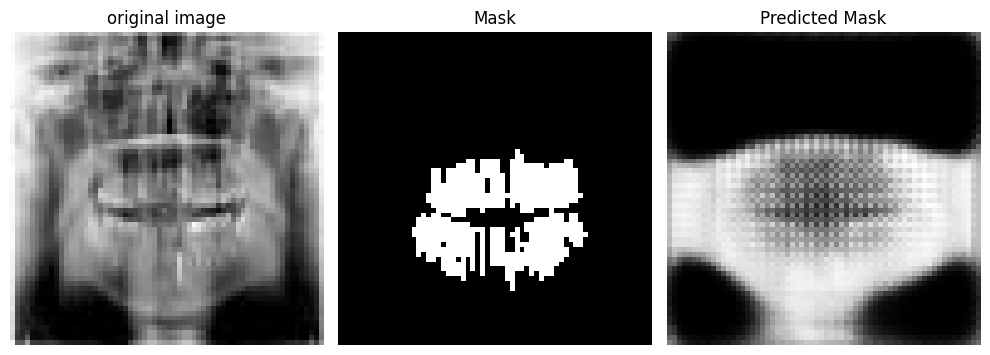

57/57 [==============================] - 102s 2s/step - loss: 0.2067 - mean_io_u: 0.4300 - accuracy: 0.9078
Epoch 2/50
1/1 [==============================] - 0s 89ms/steploss: 0.1167 - mean_io_u: 0.4300 - accuracy: 0.94


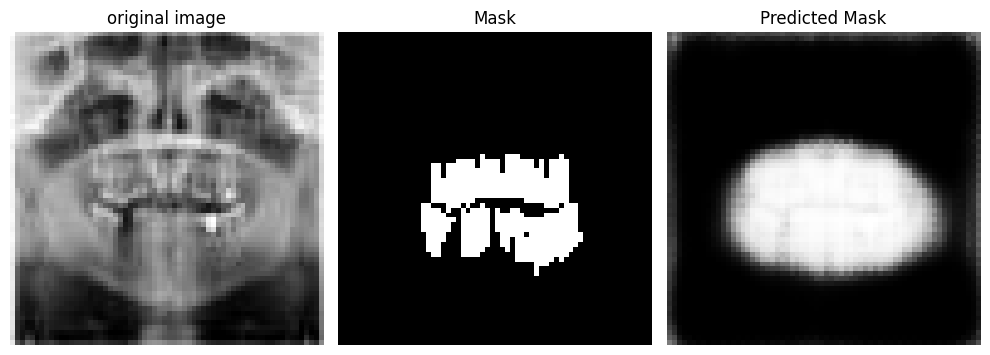

57/57 [==============================] - 94s 2s/step - loss: 0.1167 - mean_io_u: 0.4300 - accuracy: 0.9499
Epoch 3/50
1/1 [==============================] - 0s 100ms/steposs: 0.1015 - mean_io_u: 0.4300 - accuracy: 0.95


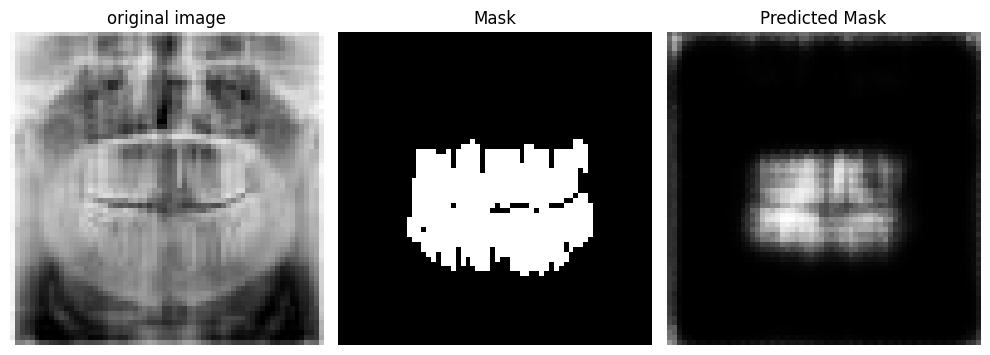

57/57 [==============================] - 93s 2s/step - loss: 0.1015 - mean_io_u: 0.4300 - accuracy: 0.9567
Epoch 4/50
1/1 [==============================] - 0s 89ms/steploss: 0.0963 - mean_io_u: 0.4300 - accuracy: 0.95


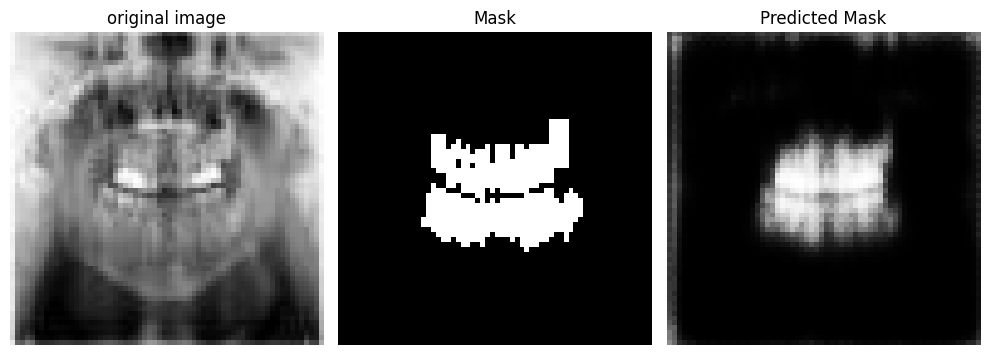

57/57 [==============================] - 93s 2s/step - loss: 0.0963 - mean_io_u: 0.4300 - accuracy: 0.9591
Epoch 5/50
1/1 [==============================] - 0s 113ms/steposs: 0.0918 - mean_io_u: 0.4300 - accuracy: 0.96


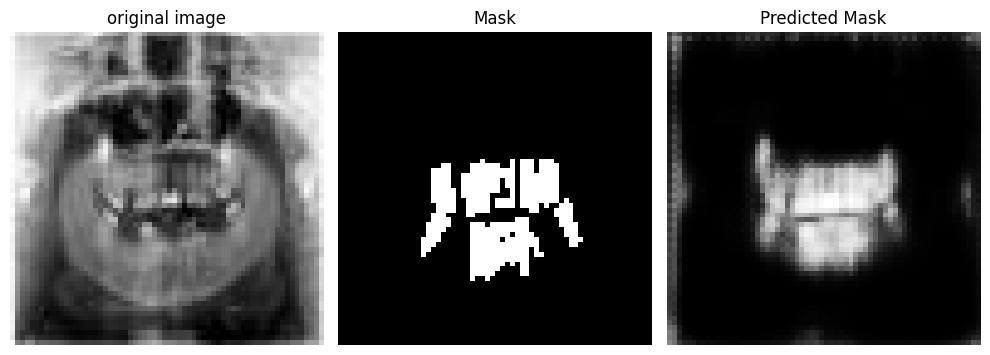

57/57 [==============================] - 93s 2s/step - loss: 0.0918 - mean_io_u: 0.4300 - accuracy: 0.9609
Epoch 6/50
1/1 [==============================] - 0s 95ms/steploss: 0.0899 - mean_io_u: 0.4300 - accuracy: 0.96


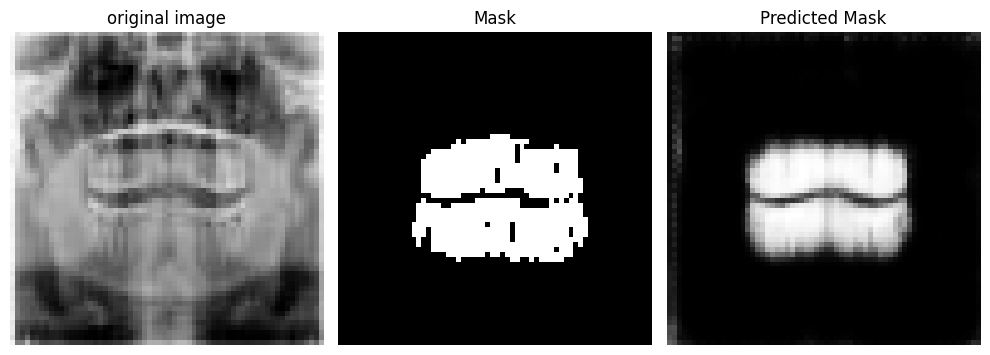

57/57 [==============================] - 93s 2s/step - loss: 0.0899 - mean_io_u: 0.4300 - accuracy: 0.9620
Epoch 7/50
1/1 [==============================] - 0s 93ms/steploss: 0.0860 - mean_io_u: 0.4300 - accuracy: 0.96


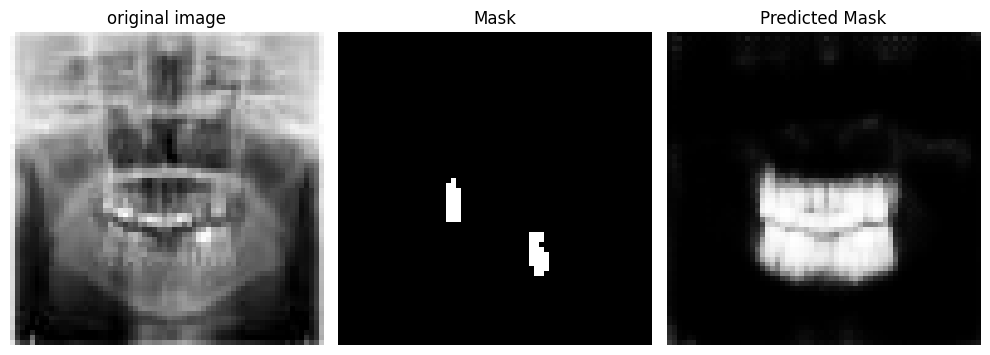

57/57 [==============================] - 93s 2s/step - loss: 0.0860 - mean_io_u: 0.4300 - accuracy: 0.9637
Epoch 8/50
1/1 [==============================] - 0s 89ms/steploss: 0.0843 - mean_io_u: 0.4300 - accuracy: 0.96


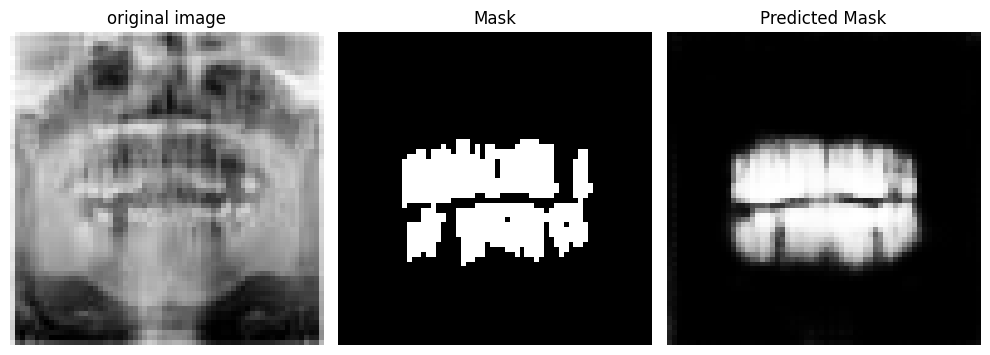

57/57 [==============================] - 93s 2s/step - loss: 0.0843 - mean_io_u: 0.4300 - accuracy: 0.9643
Epoch 9/50
1/1 [==============================] - 0s 87ms/steploss: 0.0821 - mean_io_u: 0.4300 - accuracy: 0.96


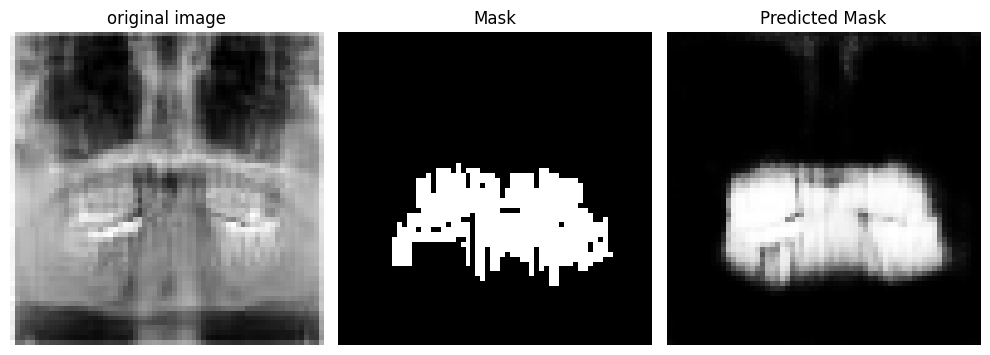

57/57 [==============================] - 93s 2s/step - loss: 0.0821 - mean_io_u: 0.4300 - accuracy: 0.9655
Epoch 10/50
1/1 [==============================] - 0s 94ms/steploss: 0.0802 - mean_io_u: 0.4300 - accuracy: 0.96


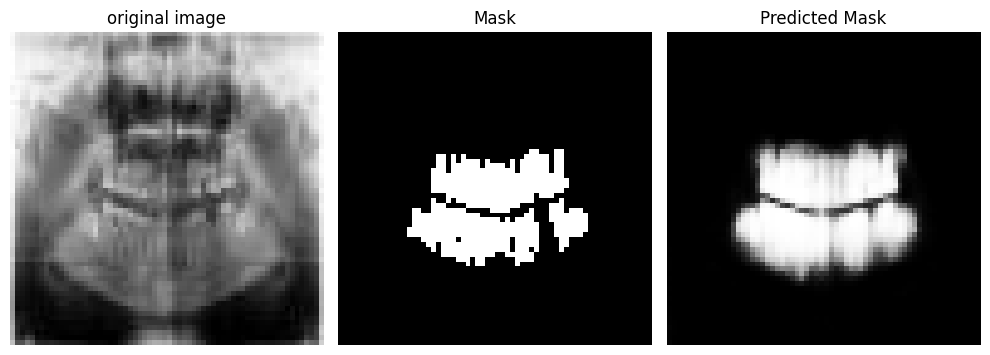

57/57 [==============================] - 93s 2s/step - loss: 0.0802 - mean_io_u: 0.4300 - accuracy: 0.9661
Epoch 11/50
1/1 [==============================] - 0s 87ms/steploss: 0.0784 - mean_io_u: 0.4300 - accuracy: 0.96


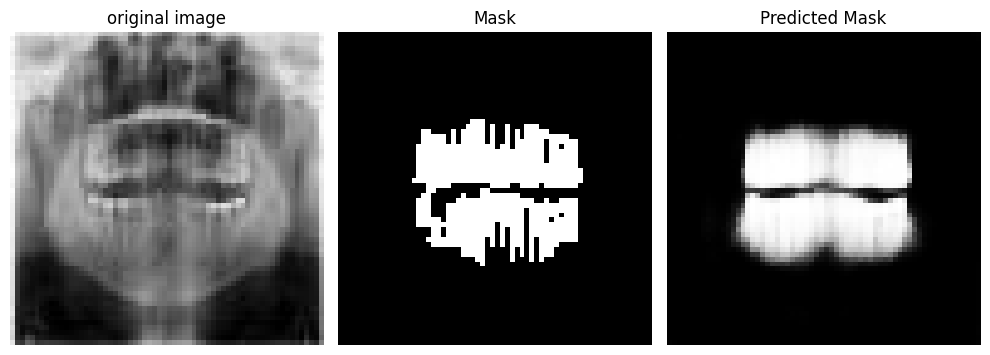

57/57 [==============================] - 93s 2s/step - loss: 0.0784 - mean_io_u: 0.4300 - accuracy: 0.9670
Epoch 12/50
1/1 [==============================] - 0s 100ms/steposs: 0.0767 - mean_io_u: 0.4300 - accuracy: 0.96


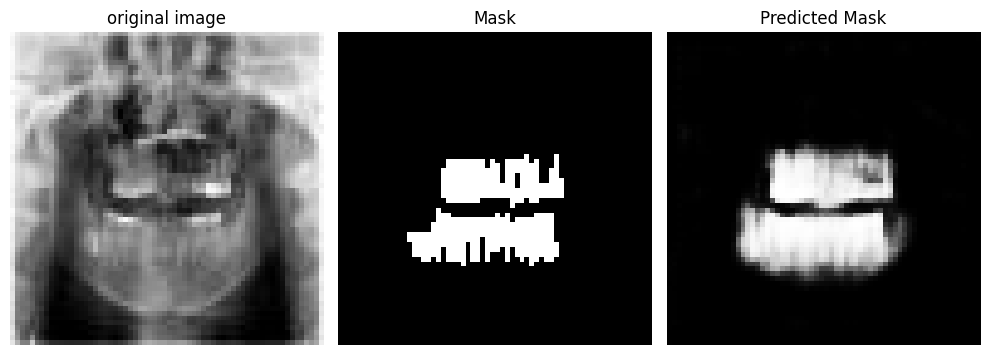

57/57 [==============================] - 93s 2s/step - loss: 0.0767 - mean_io_u: 0.4300 - accuracy: 0.9678
Epoch 13/50
1/1 [==============================] - 0s 84ms/steploss: 0.0754 - mean_io_u: 0.4300 - accuracy: 0.96


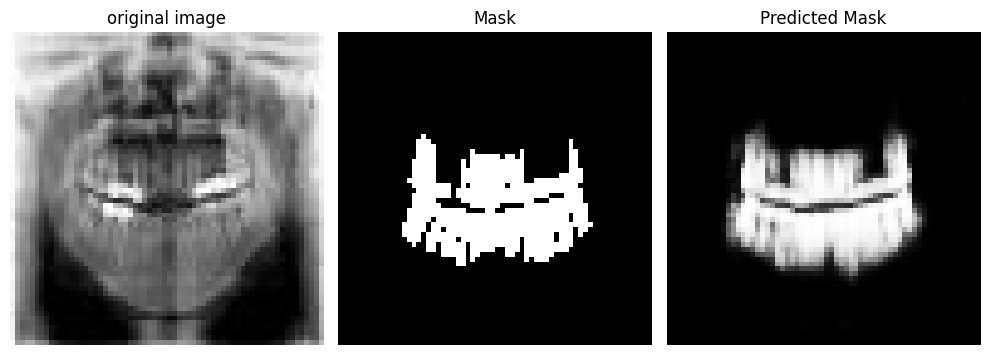

57/57 [==============================] - 93s 2s/step - loss: 0.0754 - mean_io_u: 0.4300 - accuracy: 0.9683
Epoch 14/50
1/1 [==============================] - 0s 87ms/steploss: 0.0737 - mean_io_u: 0.4300 - accuracy: 0.96


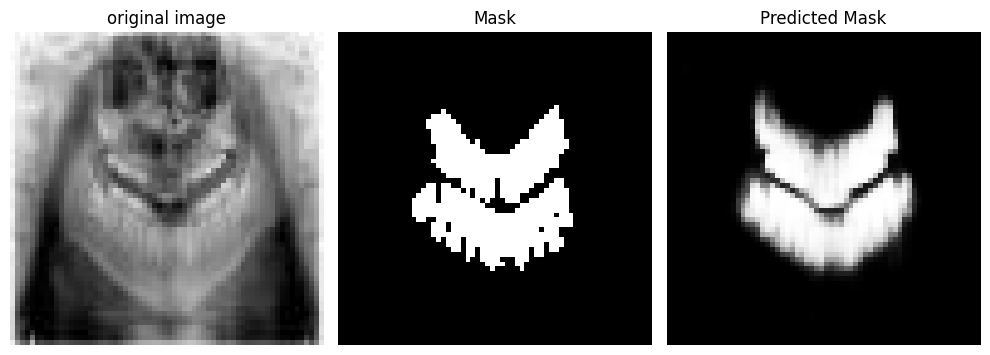

57/57 [==============================] - 92s 2s/step - loss: 0.0737 - mean_io_u: 0.4300 - accuracy: 0.9689
Epoch 15/50
1/1 [==============================] - 0s 94ms/steploss: 0.0738 - mean_io_u: 0.4300 - accuracy: 0.96


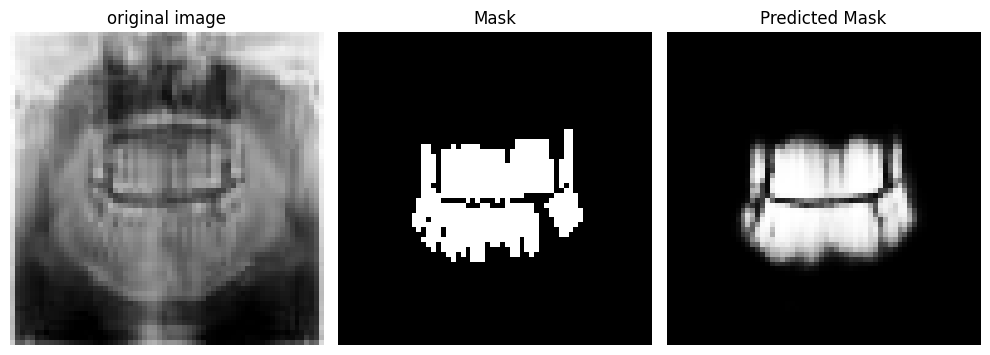

57/57 [==============================] - 93s 2s/step - loss: 0.0738 - mean_io_u: 0.4300 - accuracy: 0.9689
Epoch 16/50
1/1 [==============================] - 0s 85ms/steploss: 0.0739 - mean_io_u: 0.4300 - accuracy: 0.96


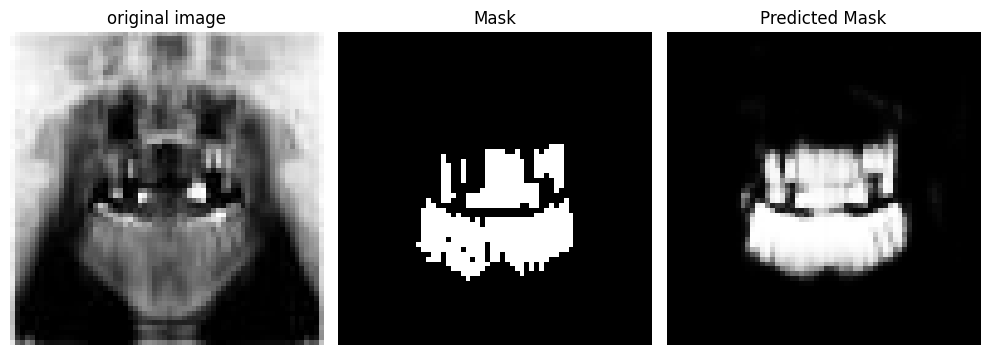

57/57 [==============================] - 93s 2s/step - loss: 0.0739 - mean_io_u: 0.4300 - accuracy: 0.9690
Epoch 17/50
1/1 [==============================] - 0s 99ms/steploss: 0.0716 - mean_io_u: 0.4300 - accuracy: 0.96


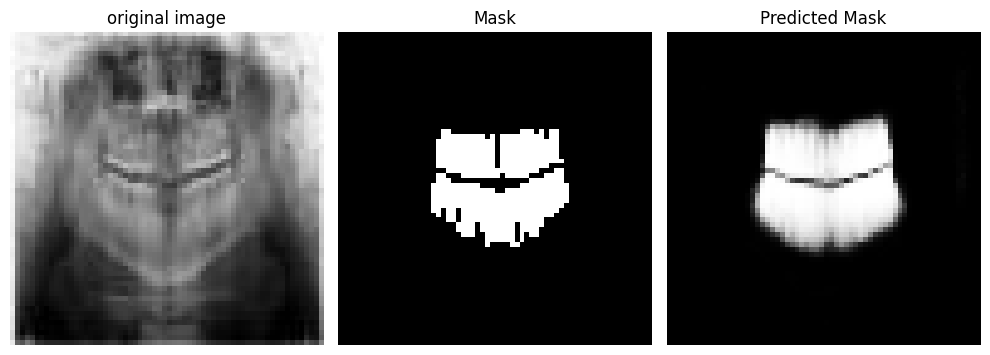

57/57 [==============================] - 93s 2s/step - loss: 0.0716 - mean_io_u: 0.4300 - accuracy: 0.9699
Epoch 18/50
1/1 [==============================] - 0s 101ms/steposs: 0.0708 - mean_io_u: 0.4300 - accuracy: 0.97


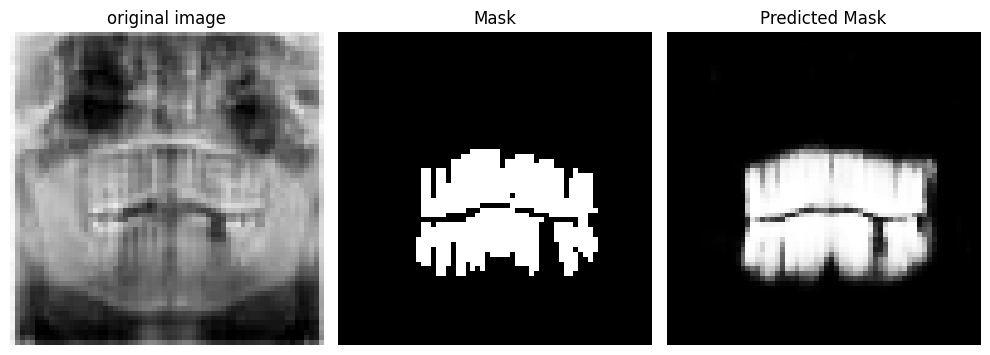

57/57 [==============================] - 93s 2s/step - loss: 0.0708 - mean_io_u: 0.4300 - accuracy: 0.9703
Epoch 19/50
1/1 [==============================] - 0s 96ms/steploss: 0.0689 - mean_io_u: 0.4300 - accuracy: 0.97


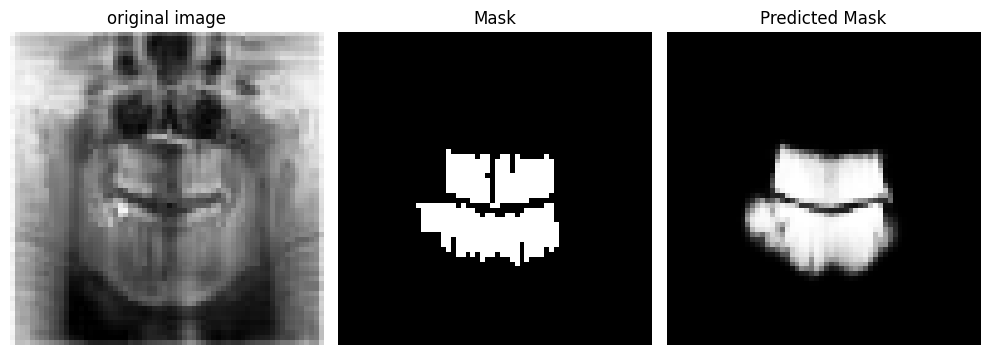

57/57 [==============================] - 93s 2s/step - loss: 0.0689 - mean_io_u: 0.4300 - accuracy: 0.9710
Epoch 20/50
1/1 [==============================] - 0s 106ms/steposs: 0.0675 - mean_io_u: 0.4300 - accuracy: 0.97


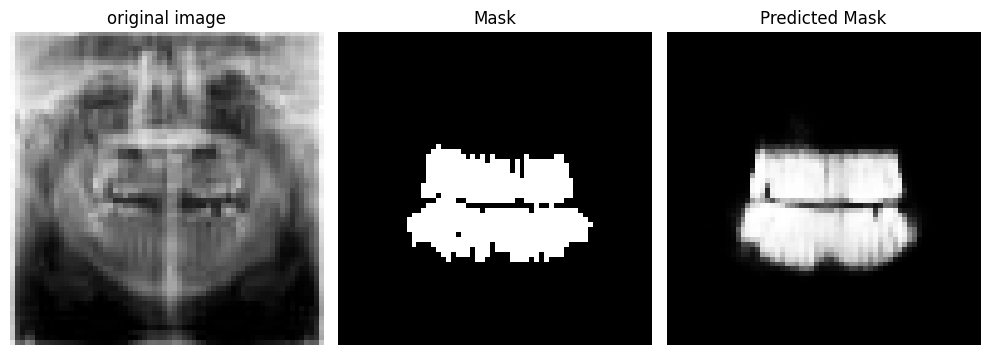

57/57 [==============================] - 92s 2s/step - loss: 0.0675 - mean_io_u: 0.4300 - accuracy: 0.9717
Epoch 21/50
1/1 [==============================] - 0s 103ms/steposs: 0.0665 - mean_io_u: 0.4300 - accuracy: 0.97


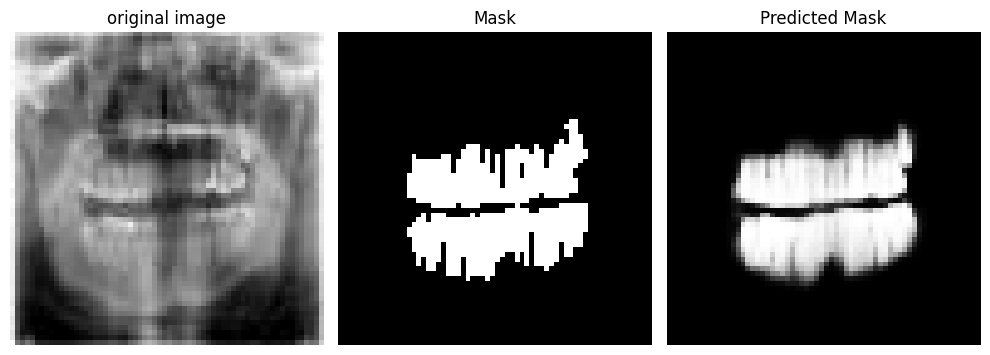

57/57 [==============================] - 92s 2s/step - loss: 0.0665 - mean_io_u: 0.4300 - accuracy: 0.9721
Epoch 22/50
1/1 [==============================] - 0s 86ms/steploss: 0.0653 - mean_io_u: 0.4300 - accuracy: 0.97


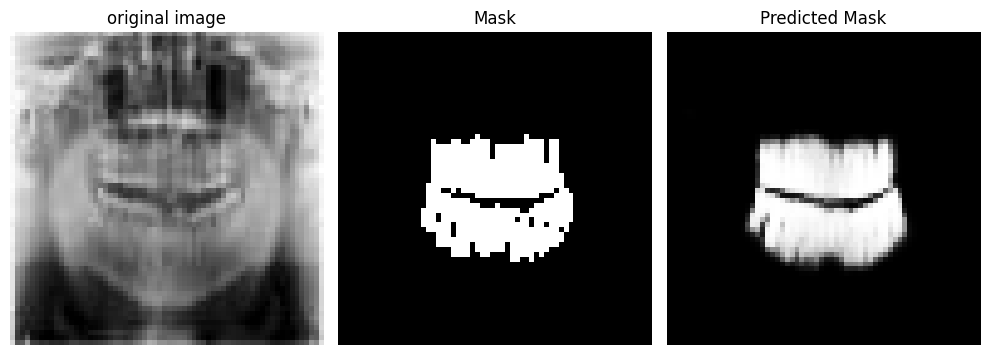

57/57 [==============================] - 92s 2s/step - loss: 0.0653 - mean_io_u: 0.4300 - accuracy: 0.9725
Epoch 23/50
1/1 [==============================] - 0s 89ms/steploss: 0.0652 - mean_io_u: 0.4300 - accuracy: 0.97


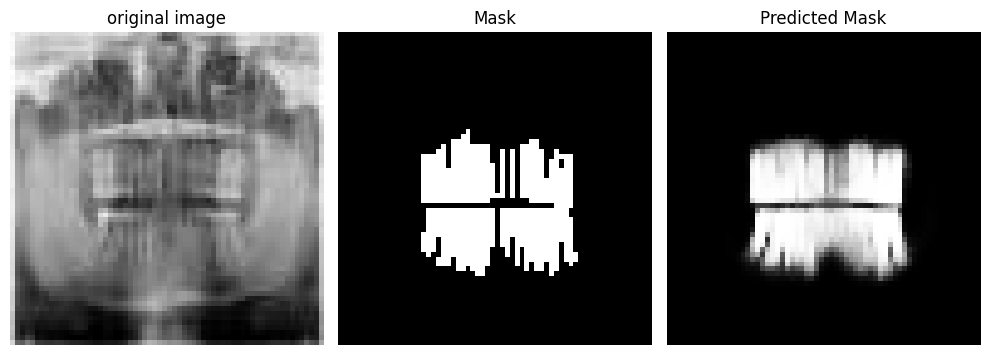

57/57 [==============================] - 92s 2s/step - loss: 0.0652 - mean_io_u: 0.4300 - accuracy: 0.9724
Epoch 24/50
1/1 [==============================] - 0s 89ms/steploss: 0.0638 - mean_io_u: 0.4300 - accuracy: 0.97


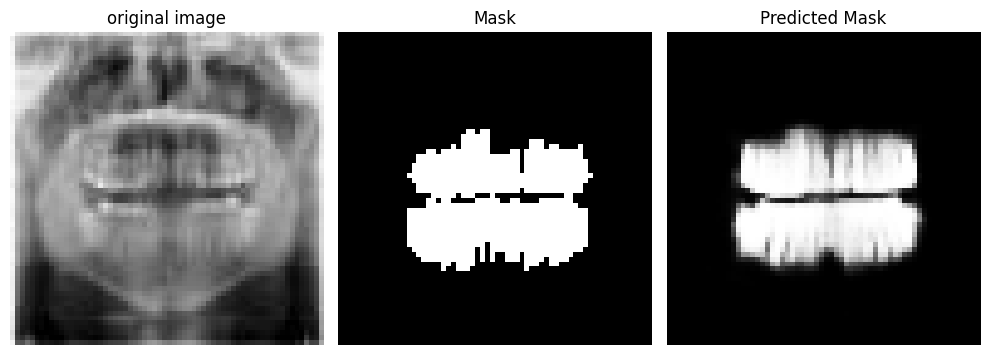

57/57 [==============================] - 92s 2s/step - loss: 0.0638 - mean_io_u: 0.4300 - accuracy: 0.9730
Epoch 25/50
1/1 [==============================] - 0s 88ms/steploss: 0.0625 - mean_io_u: 0.4300 - accuracy: 0.97


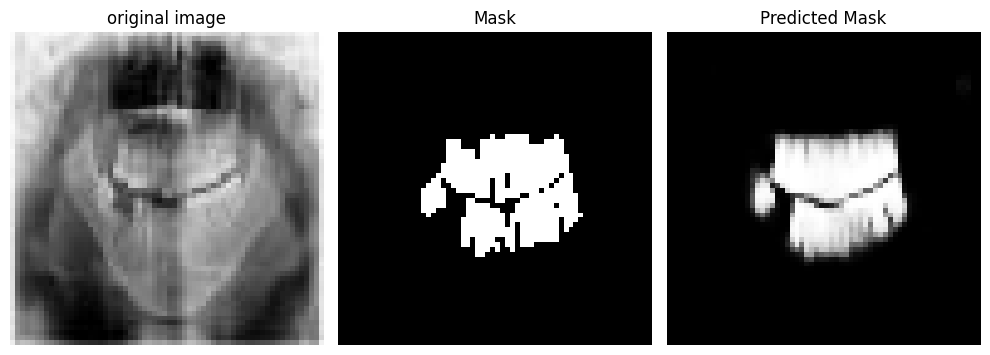

57/57 [==============================] - 92s 2s/step - loss: 0.0625 - mean_io_u: 0.4300 - accuracy: 0.9735
Epoch 26/50
1/1 [==============================] - 0s 89ms/steploss: 0.0615 - mean_io_u: 0.4300 - accuracy: 0.97


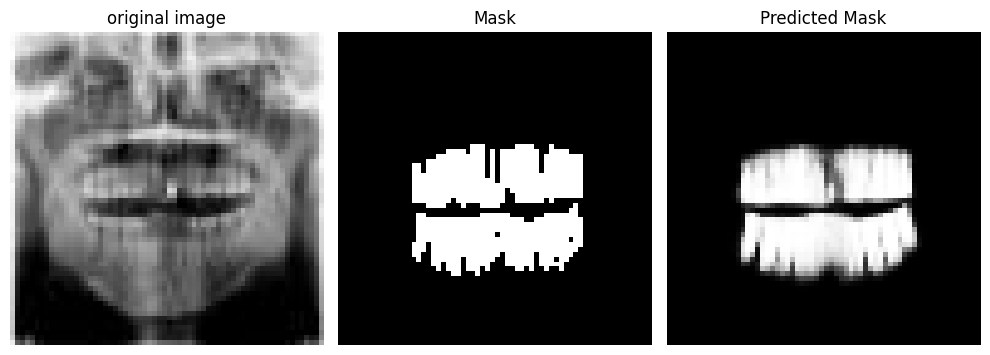

57/57 [==============================] - 93s 2s/step - loss: 0.0615 - mean_io_u: 0.4300 - accuracy: 0.9740
Epoch 27/50
1/1 [==============================] - 0s 102ms/steposs: 0.0602 - mean_io_u: 0.4300 - accuracy: 0.97


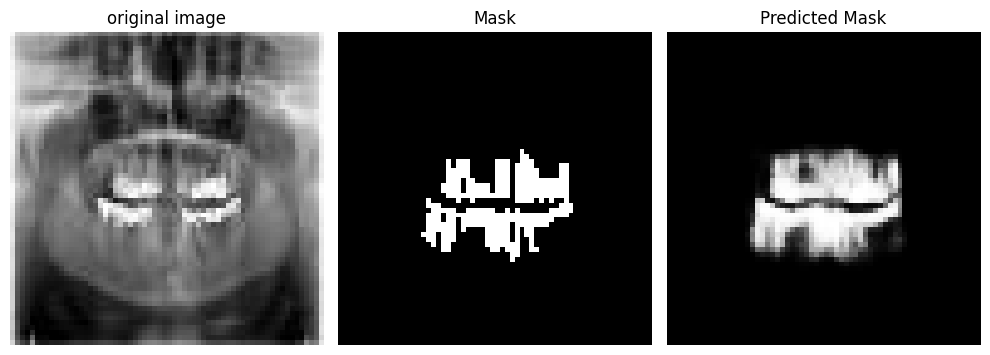

57/57 [==============================] - 92s 2s/step - loss: 0.0602 - mean_io_u: 0.4300 - accuracy: 0.9747
Epoch 28/50
1/1 [==============================] - 0s 127ms/steposs: 0.0591 - mean_io_u: 0.4300 - accuracy: 0.97


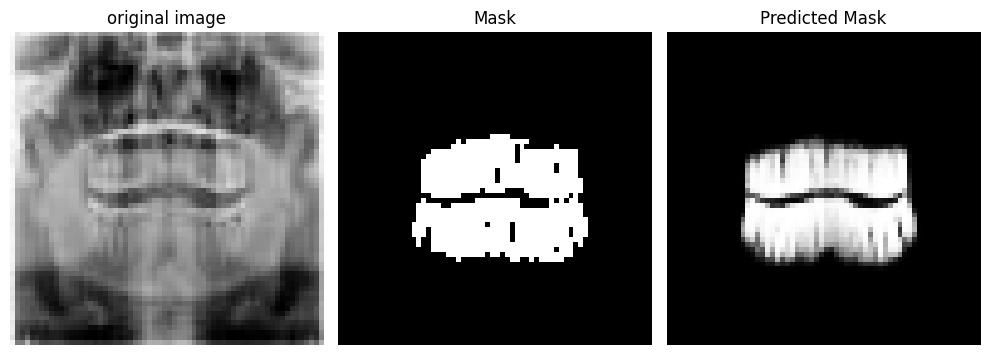

57/57 [==============================] - 92s 2s/step - loss: 0.0591 - mean_io_u: 0.4300 - accuracy: 0.9750
Epoch 29/50
1/1 [==============================] - 0s 95ms/steploss: 0.0596 - mean_io_u: 0.4300 - accuracy: 0.97


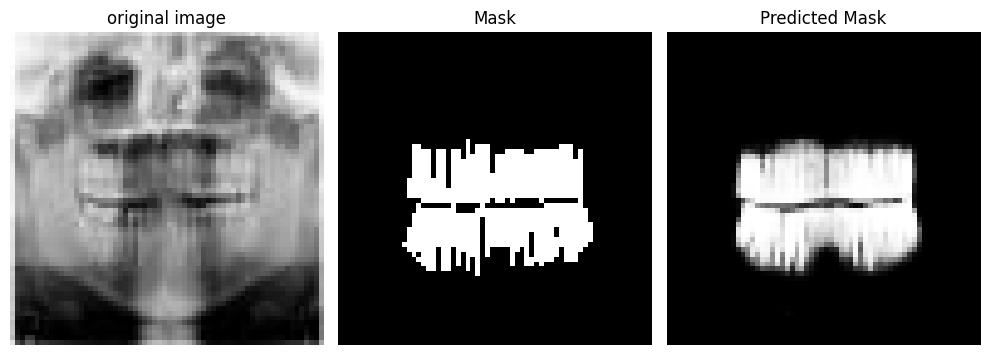

57/57 [==============================] - 93s 2s/step - loss: 0.0596 - mean_io_u: 0.4300 - accuracy: 0.9749
Epoch 30/50
1/1 [==============================] - 0s 93ms/steploss: 0.0568 - mean_io_u: 0.4300 - accuracy: 0.97


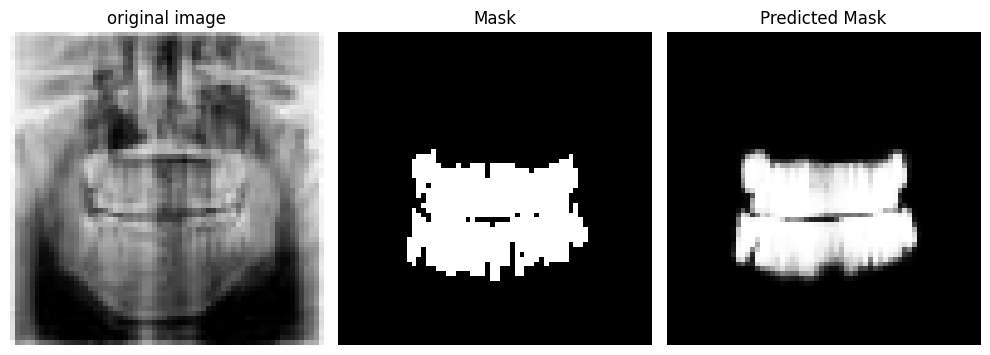

57/57 [==============================] - 93s 2s/step - loss: 0.0568 - mean_io_u: 0.4300 - accuracy: 0.9760
Epoch 31/50
1/1 [==============================] - 0s 92ms/steploss: 0.0566 - mean_io_u: 0.4300 - accuracy: 0.97


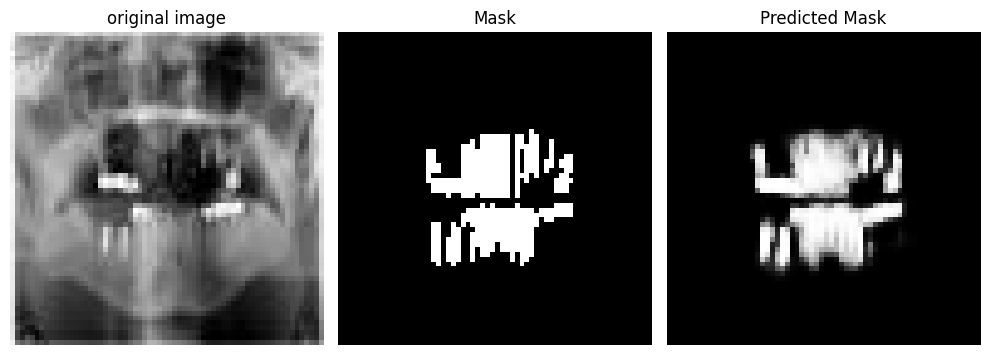

57/57 [==============================] - 94s 2s/step - loss: 0.0566 - mean_io_u: 0.4300 - accuracy: 0.9761
Epoch 32/50
1/1 [==============================] - 0s 89ms/steploss: 0.0556 - mean_io_u: 0.4300 - accuracy: 0.97


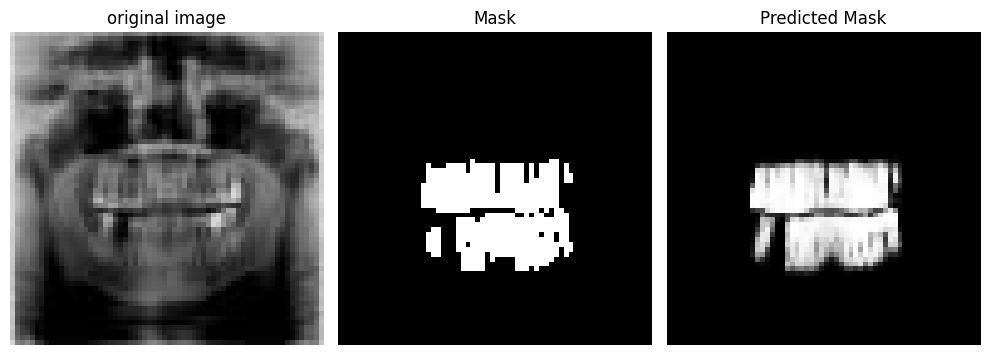

57/57 [==============================] - 94s 2s/step - loss: 0.0556 - mean_io_u: 0.4300 - accuracy: 0.9764
Epoch 33/50
1/1 [==============================] - 0s 90ms/steploss: 0.0546 - mean_io_u: 0.4300 - accuracy: 0.97


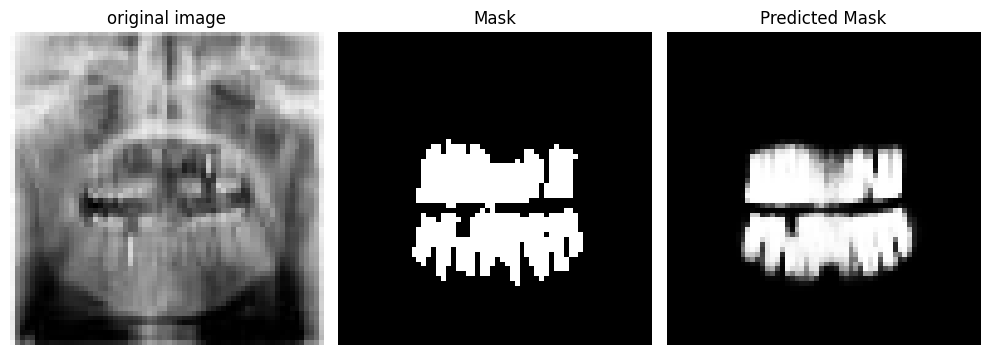

57/57 [==============================] - 94s 2s/step - loss: 0.0546 - mean_io_u: 0.4300 - accuracy: 0.9769
Epoch 34/50
1/1 [==============================] - 0s 95ms/steploss: 0.0534 - mean_io_u: 0.4300 - accuracy: 0.97


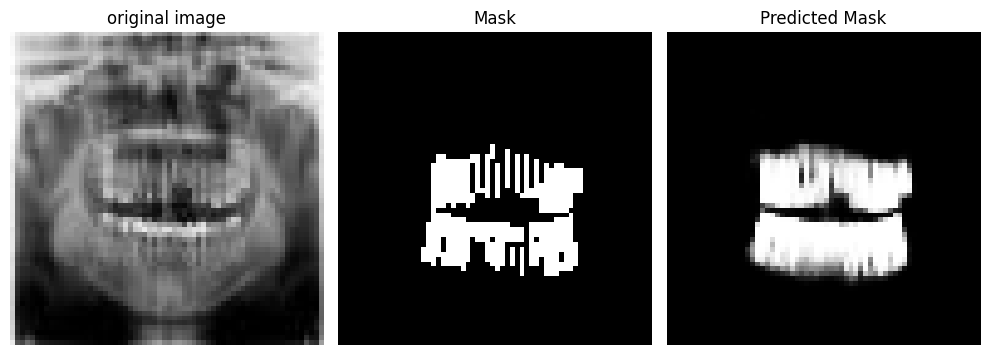

57/57 [==============================] - 93s 2s/step - loss: 0.0534 - mean_io_u: 0.4300 - accuracy: 0.9774
Epoch 35/50
1/1 [==============================] - 0s 94ms/steploss: 0.0528 - mean_io_u: 0.4300 - accuracy: 0.97


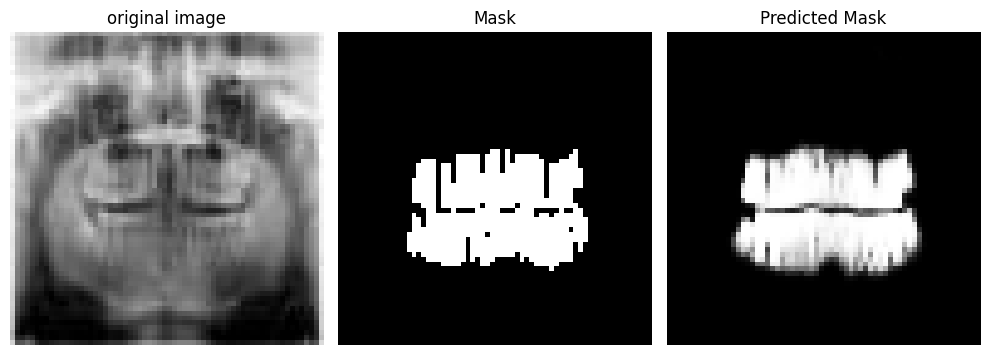

57/57 [==============================] - 94s 2s/step - loss: 0.0528 - mean_io_u: 0.4300 - accuracy: 0.9776
Epoch 36/50
1/1 [==============================] - 0s 97ms/steploss: 0.0517 - mean_io_u: 0.4300 - accuracy: 0.97


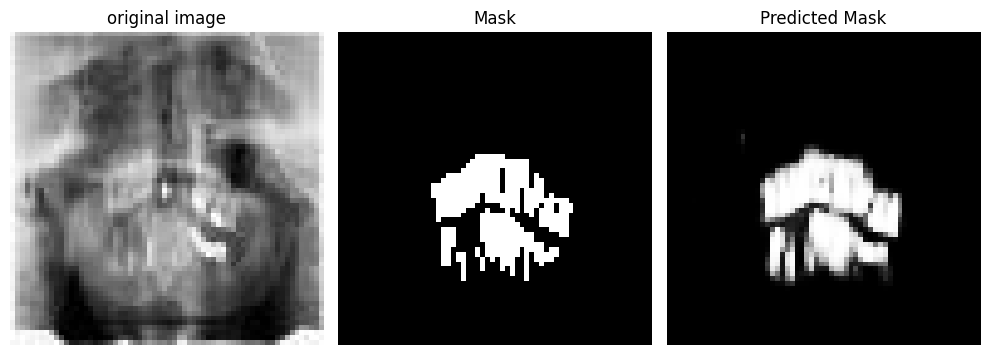

57/57 [==============================] - 93s 2s/step - loss: 0.0517 - mean_io_u: 0.4300 - accuracy: 0.9782
Epoch 37/50
1/1 [==============================] - 0s 96ms/steploss: 0.0516 - mean_io_u: 0.4300 - accuracy: 0.97


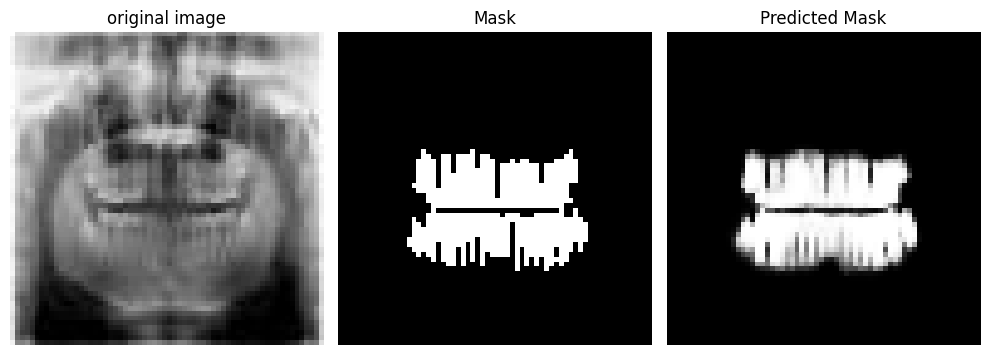

57/57 [==============================] - 93s 2s/step - loss: 0.0516 - mean_io_u: 0.4300 - accuracy: 0.9782
Epoch 38/50
1/1 [==============================] - 0s 106ms/steposs: 0.0494 - mean_io_u: 0.4300 - accuracy: 0.97


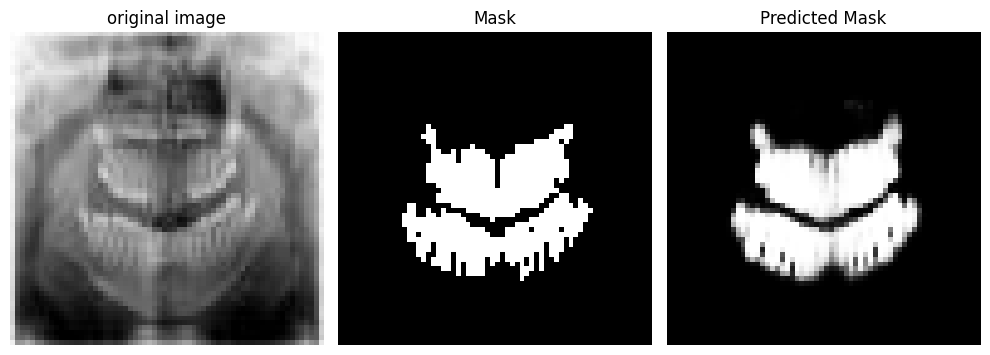

57/57 [==============================] - 93s 2s/step - loss: 0.0494 - mean_io_u: 0.4300 - accuracy: 0.9791
Epoch 39/50
1/1 [==============================] - 0s 111ms/steposs: 0.0480 - mean_io_u: 0.4300 - accuracy: 0.97


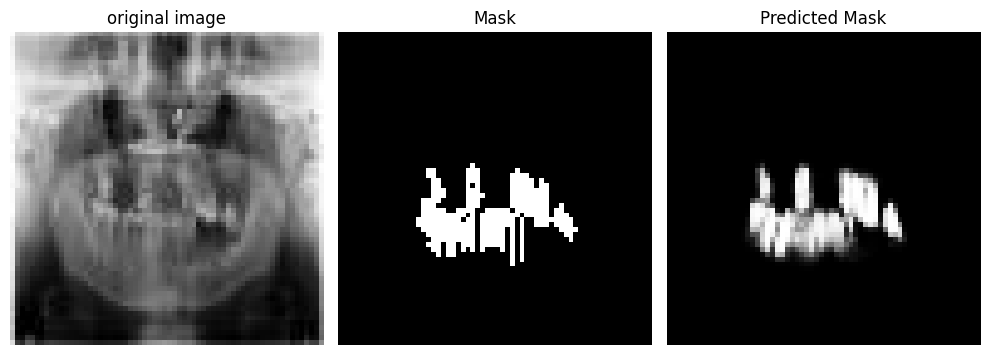

57/57 [==============================] - 94s 2s/step - loss: 0.0480 - mean_io_u: 0.4300 - accuracy: 0.9796
Epoch 40/50
1/1 [==============================] - 0s 86ms/steploss: 0.0485 - mean_io_u: 0.4301 - accuracy: 0.97


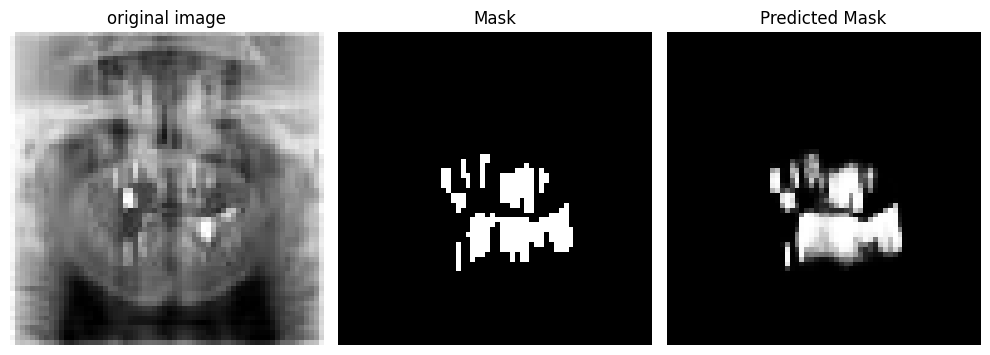

57/57 [==============================] - 93s 2s/step - loss: 0.0485 - mean_io_u: 0.4301 - accuracy: 0.9795
Epoch 41/50
1/1 [==============================] - 0s 92ms/steploss: 0.0475 - mean_io_u: 0.4301 - accuracy: 0.98


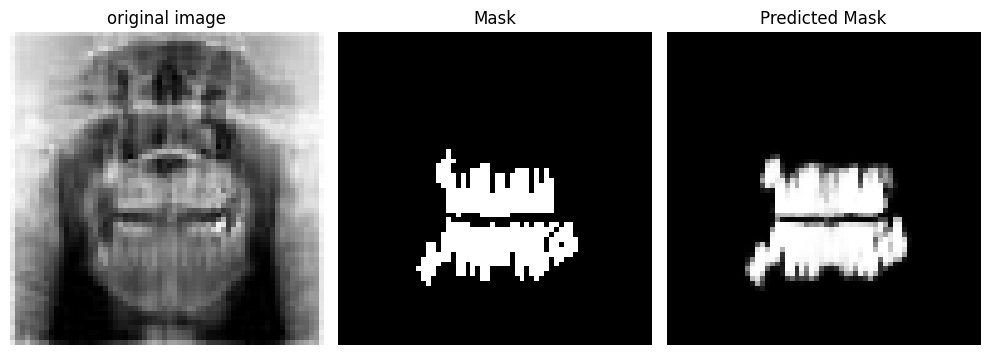

57/57 [==============================] - 93s 2s/step - loss: 0.0475 - mean_io_u: 0.4301 - accuracy: 0.9800
Epoch 42/50
1/1 [==============================] - 0s 95ms/steploss: 0.0465 - mean_io_u: 0.4303 - accuracy: 0.98


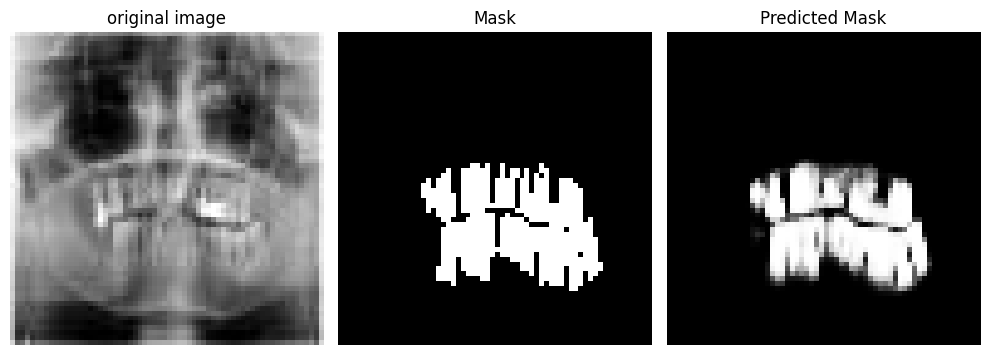

57/57 [==============================] - 93s 2s/step - loss: 0.0465 - mean_io_u: 0.4303 - accuracy: 0.9802
Epoch 43/50
1/1 [==============================] - 0s 94ms/steploss: 0.0447 - mean_io_u: 0.4304 - accuracy: 0.98


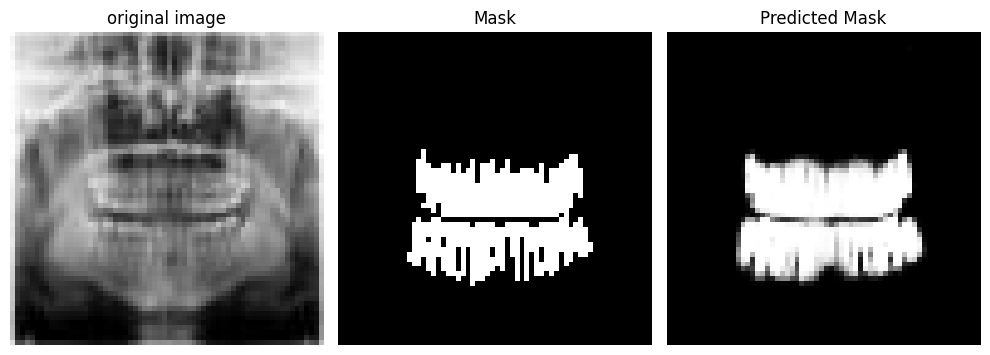

57/57 [==============================] - 93s 2s/step - loss: 0.0447 - mean_io_u: 0.4304 - accuracy: 0.9811
Epoch 44/50
1/1 [==============================] - 0s 91ms/steploss: 0.0438 - mean_io_u: 0.4306 - accuracy: 0.98


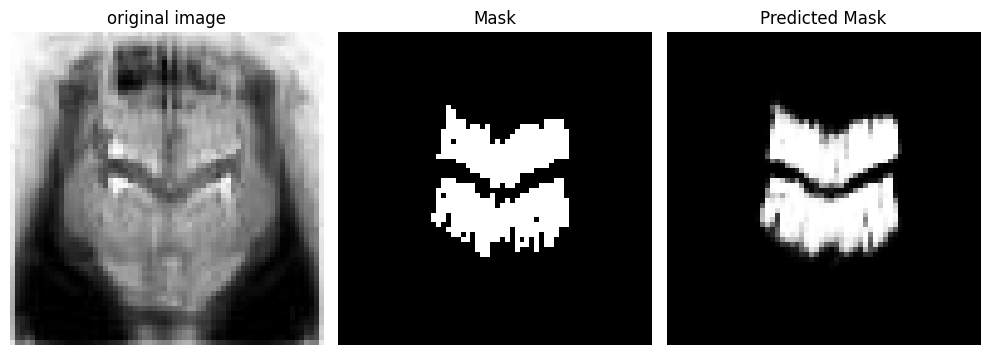

57/57 [==============================] - 93s 2s/step - loss: 0.0438 - mean_io_u: 0.4306 - accuracy: 0.9814
Epoch 45/50
1/1 [==============================] - 0s 91ms/steploss: 0.0429 - mean_io_u: 0.4306 - accuracy: 0.98


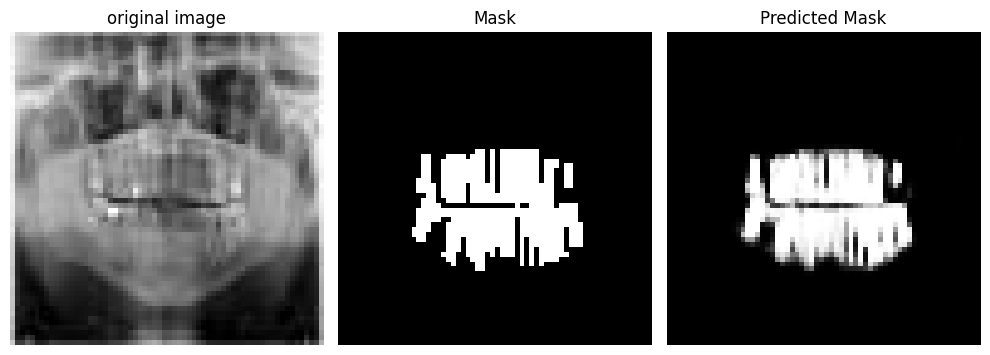

57/57 [==============================] - 93s 2s/step - loss: 0.0429 - mean_io_u: 0.4306 - accuracy: 0.9819
Epoch 46/50
1/1 [==============================] - 0s 107ms/steposs: 0.0413 - mean_io_u: 0.4310 - accuracy: 0.98


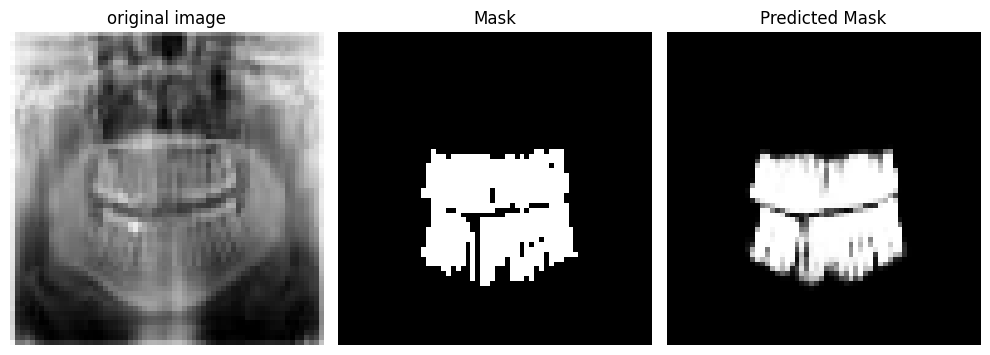

57/57 [==============================] - 94s 2s/step - loss: 0.0413 - mean_io_u: 0.4310 - accuracy: 0.9826
Epoch 47/50
1/1 [==============================] - 0s 100ms/steposs: 0.0401 - mean_io_u: 0.4312 - accuracy: 0.98


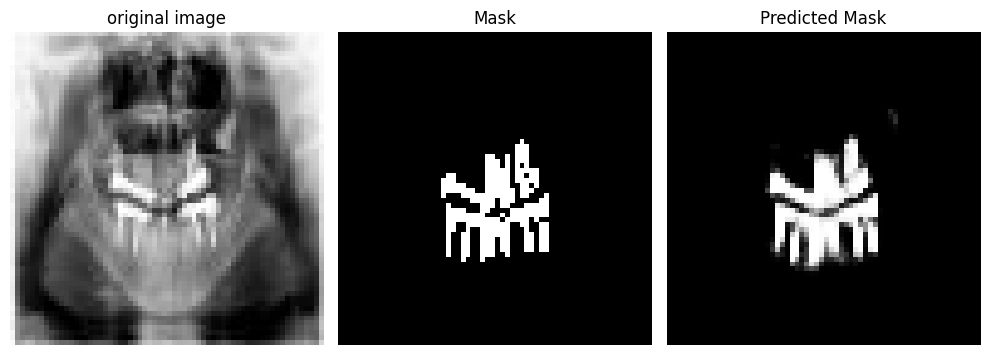

57/57 [==============================] - 92s 2s/step - loss: 0.0401 - mean_io_u: 0.4312 - accuracy: 0.9830
Epoch 48/50
1/1 [==============================] - 0s 92ms/steploss: 0.0411 - mean_io_u: 0.4314 - accuracy: 0.98


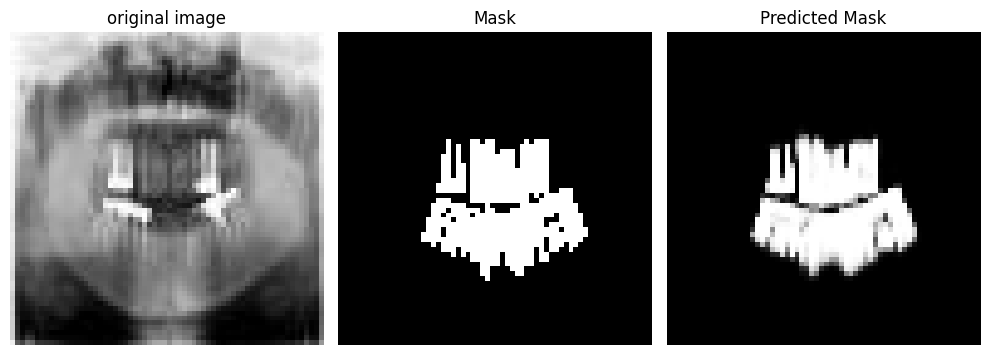

57/57 [==============================] - 93s 2s/step - loss: 0.0411 - mean_io_u: 0.4314 - accuracy: 0.9826
Epoch 49/50
1/1 [==============================] - 0s 97ms/steploss: 0.0387 - mean_io_u: 0.4317 - accuracy: 0.98


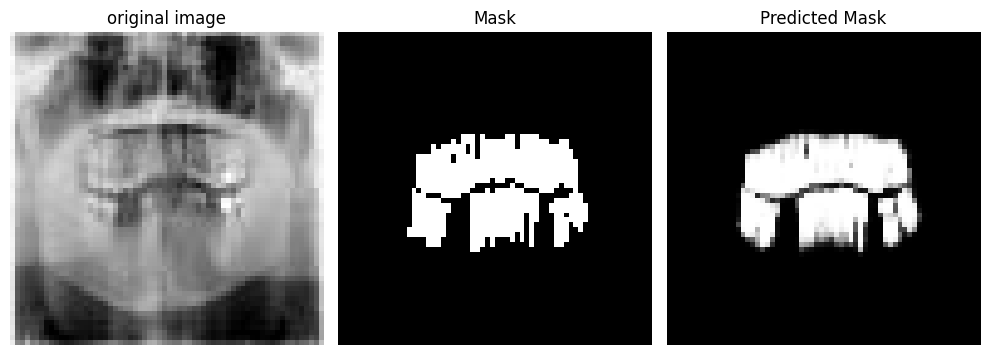

57/57 [==============================] - 93s 2s/step - loss: 0.0387 - mean_io_u: 0.4317 - accuracy: 0.9837
Epoch 50/50
1/1 [==============================] - 0s 96ms/steploss: 0.0381 - mean_io_u: 0.4325 - accuracy: 0.98


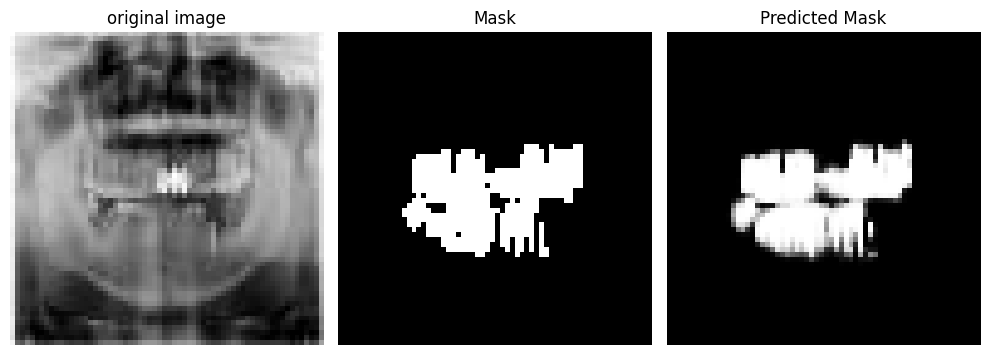

57/57 [==============================] - 93s 2s/step - loss: 0.0381 - mean_io_u: 0.4325 - accuracy: 0.9839


In [32]:
model.fit(tn_img_arrays,train_mask_y,batch_size=8,epochs=50,verbose=1,callbacks=cbs)